In [1]:
import pandas as pd
import numpy as np

import os.path as op
import sys

sys.path.append(op.abspath('../code'))

import plotting_tools

import importlib

import data_loaders as dload
import clusterize as cluster

In [2]:
path_to_xls = '/Users/hugofluhr/Downloads/Piriform_neurons/data'
my_matrix = dload.get_neuron_matrix(path_to_xls)
my_matrix

/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 37 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 37 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 51 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 46 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 66 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 46 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 27 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 33 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 21 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 74 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 23 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 59 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 32 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 87 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 62 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 87 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 64 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 48 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 64 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 34 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 52 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 28 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 144 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 39 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 94 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 298 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 123 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 51 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 26 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 72 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 19 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 32 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 58 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 111 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 237 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 23 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 73 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 33 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 33 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 20 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 30 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 26 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 72 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 51 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 43 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 104 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 32 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 79 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 32 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 45 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 41 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 61 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 87 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 42 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 70 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 36 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 35 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 61 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 98 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 81 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 23 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 40 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 64 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 37 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 35 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 144 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 28 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


Successfully converted data from 36 dendrites (30 features found).
Successfully converted data from 52 dendrites (30 features found).


/Users/hugofluhr/code/piriform-cortex-diversity/code/data_loaders.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Collection_x'} in the result is deprecated and will raise a MergeError in a future version.
  dendrite_df = dendrite_df.merge(feat_df, on = 'ID', how = 'outer')


,Filament BoundingBoxAA Length X,Filament BoundingBoxAA Length Y,Filament BoundingBoxAA Length Z,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
220803c2,397.671997,367.519012,74.598099,78.401199,300.372986,481.835999,3199.409912,588.359009,1.000000,1.500000,...,1.826087,33.507574,25.262470,82.586829,-48.273287,0.929221,37.0,23.0,14.0,18.0
220728c6,599.765991,406.221008,84.741898,76.656898,250.242004,641.146973,3125.620117,588.575989,2.700000,2.250000,...,1.375000,23.235501,20.388471,63.169632,-8.584363,0.902760,51.0,16.0,20.0,19.0
220804c2,515.750000,548.078003,41.285400,46.428600,529.473022,526.778992,3914.820068,444.289001,1.714286,1.428571,...,1.375000,36.824632,32.913235,74.645122,-14.950824,0.911412,46.0,16.0,7.0,21.0
220831c4,232.867996,210.024002,33.973202,31.313101,139.182007,292.226990,1386.290039,434.790985,3.333333,2.809524,...,2.477273,34.713013,45.723158,20.376204,21.603243,0.938812,66.0,44.0,21.0,13.0
220729c3,460.346008,375.755005,56.962799,63.419399,359.394012,468.649994,4130.500000,625.966003,2.142857,1.714286,...,2.625000,30.743026,23.891336,88.418938,-46.275719,0.915908,46.0,32.0,14.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220802c9,561.872986,546.406006,47.063400,49.915001,577.502991,537.882019,2837.000000,1120.599976,4.206897,2.310345,...,1.200000,16.306020,14.798380,32.718801,-66.440581,0.940670,35.0,5.0,29.0,12.0
220728c5,18.957300,81.177200,48.012199,7.305410,20.284300,93.685097,115.085999,736.338989,3.675000,2.750000,...,1.681818,16.830166,28.140820,61.109693,-0.822688,0.899236,144.0,38.0,80.0,32.0
220804c1,219.255997,334.191010,22.972700,21.813299,116.309998,363.174988,1607.780029,544.145020,2.375000,2.562500,...,1.916667,39.687725,40.980310,38.972638,-50.896333,0.884011,28.0,12.0,16.0,9.0


In [6]:
is_na_idx = np.where(my_matrix.isna())[0]
print(is_na_idx)
my_matrix.iloc[is_na_idx]

[28 28 28 28 28 28 28 28 38 38 38 38 38 38 38 38 55 55 55 55]


,Filament BoundingBoxAA Length X,Filament BoundingBoxAA Length Y,Filament BoundingBoxAA Length Z,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
221005c1,598.138000,626.291016,92.129303,95.135399,599.177979,698.518982,4335.859863,840.005005,2.5,2.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,12.0,14.0
220803c5,280.454010,169.817993,59.319901,48.362202,175.466995,277.036011,1014.390015,683.142029,3.3,1.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,20.0,8.0


In [7]:
cluster_df = my_matrix.dropna(axis = 0).apply(cluster.normalize).dropna(axis = 1)

feat_to_del = ['Filament BoundingBoxAA Length X', 'Filament BoundingBoxAA Length Y', 'Filament BoundingBoxAA Length Z']
cluster_df = cluster_df.drop(columns = feat_to_del)

print(cluster_df.shape)

cluster_df

(65, 23)


,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,Dendrite Branching Angle-Apical-mean,Dendrite Branching Angle B-Apical-mean,Dendrite Length-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
id,,,,,,,,,,,,,,,,,,,,,
220803c2,1.046957,-0.157664,-0.127838,-0.043211,-0.679552,-1.176441,-1.062344,-0.527270,-1.156670,1.760207,...,-0.149285,0.795178,0.065493,0.670288,-0.073439,0.566016,-0.515663,-0.094490,-0.667321,0.474851
220728c6,0.972651,-0.493095,0.643825,-0.078762,-0.678532,-0.086585,-0.071150,-0.045484,-0.699440,0.497389,...,-0.818476,-0.214589,-0.334045,-0.054428,0.682635,-0.178700,-0.218667,-0.390991,-0.361138,0.626152
220804c2,-0.315055,1.375265,0.089855,0.301461,-1.356344,-0.718518,-1.156743,-0.145711,1.157574,1.162727,...,-0.818476,1.121252,0.692651,0.373877,0.561354,0.064805,-0.324737,-0.390991,-1.024533,0.928753
220831c4,-0.958965,-1.236208,-1.046257,-0.916740,-1.400962,0.319440,0.668312,0.619731,2.151415,-2.048692,...,0.816752,0.913675,1.742722,-1.651625,1.257708,0.835960,0.099543,0.795015,-0.310108,-0.281652
220729c3,0.408742,0.237251,-0.191708,0.405371,-0.502887,-0.443764,-0.779145,0.525485,0.130924,1.764829,...,1.035907,0.523417,-0.046903,0.887963,-0.035385,0.191340,-0.324737,0.286727,-0.667321,-0.432952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220802c9,-0.166537,1.696638,0.143635,-0.217814,1.820737,0.879474,0.008601,0.628539,0.818158,1.721922,...,-1.078089,-0.895772,-0.792283,-1.190957,-0.419526,0.888262,-0.558091,-0.856922,0.098135,-0.432952
220728c5,-1.981677,-2.031763,-2.007945,-1.529184,0.015608,0.538480,0.589646,-0.429108,0.131125,0.300169,...,-0.363309,-0.844247,0.301441,-0.131312,0.830494,-0.277890,1.754233,0.540871,2.700686,2.593059
220804c1,-1.363651,-1.389247,-0.702603,-0.810031,-0.887254,-0.294940,0.341847,1.249260,-0.210181,0.555046,...,-0.014910,1.402700,1.353935,-0.957542,-0.123408,-0.706395,-0.706589,-0.560421,-0.565260,-0.886854


Clustering yielded 5 clusters
Groups: [19, 32, 3, 8, 3]


,avg_radius,max_radius,feat_by_radius,Filament BoundingBoxOO Length A,Filament BoundingBoxOO Length B,Filament BoundingBoxOO Length C,Filament Dendrite Length (sum),Filament Distance from Origin,Depth-Apical-mean,Level-Apical-mean,...,Level-Basal-mean,Dendrite Branching Angle-Basal-mean,Dendrite Branching Angle B-Basal-mean,Dendrite Length-Basal-mean,Dendrite Orientation Angle-Basal-mean,Dendrite Straightness-Basal-mean,dendrites-count,Basal-count,Apical-count,level_1-count
0,4.058349,5.470221,"[Apical-count, dendrites-count, Dendrite Branc...",13.131071,14.22876,14.156266,11.349068,16.708336,9.086226,12.363642,...,12.441416,8.789239,12.047987,16.139602,18.995446,14.456816,7.777714,13.046072,5.484425,11.785517
1,3.670922,5.510725,"[dendrites-count, Basal-count, Dendrite Orient...",26.514838,25.597076,23.603757,15.972702,26.997908,16.419828,17.208143,...,10.534575,27.446053,25.686677,28.754803,15.494564,26.659987,8.268148,8.503244,15.002937,16.680886
2,4.516916,4.96769,"[Dendrite Branching Angle-Basal-mean, Dendrite...",3.139129,1.27716,0.737213,1.743451,1.654041,4.381005,4.730499,...,2.782318,0.415947,0.508277,1.37385,1.186699,1.79699,4.087226,3.445067,4.048412,3.328612
3,2.82048,5.099673,"[Depth-Basal-mean, Dendrite Branching Angle B-...",5.894598,5.870302,6.614596,6.587924,3.346672,4.433904,3.002319,...,2.19857,4.102245,1.757053,2.589872,2.320063,2.234771,3.373022,5.040528,5.256131,7.262427
4,2.367714,2.560969,"[Dendrite Branching Angle B-Apical-mean, Depth...",2.955858,0.538468,0.795641,1.206354,0.726355,0.0,0.0,...,1.648001,0.601116,0.858789,1.954069,0.947516,0.271821,0.947558,1.891963,0.0,2.319942


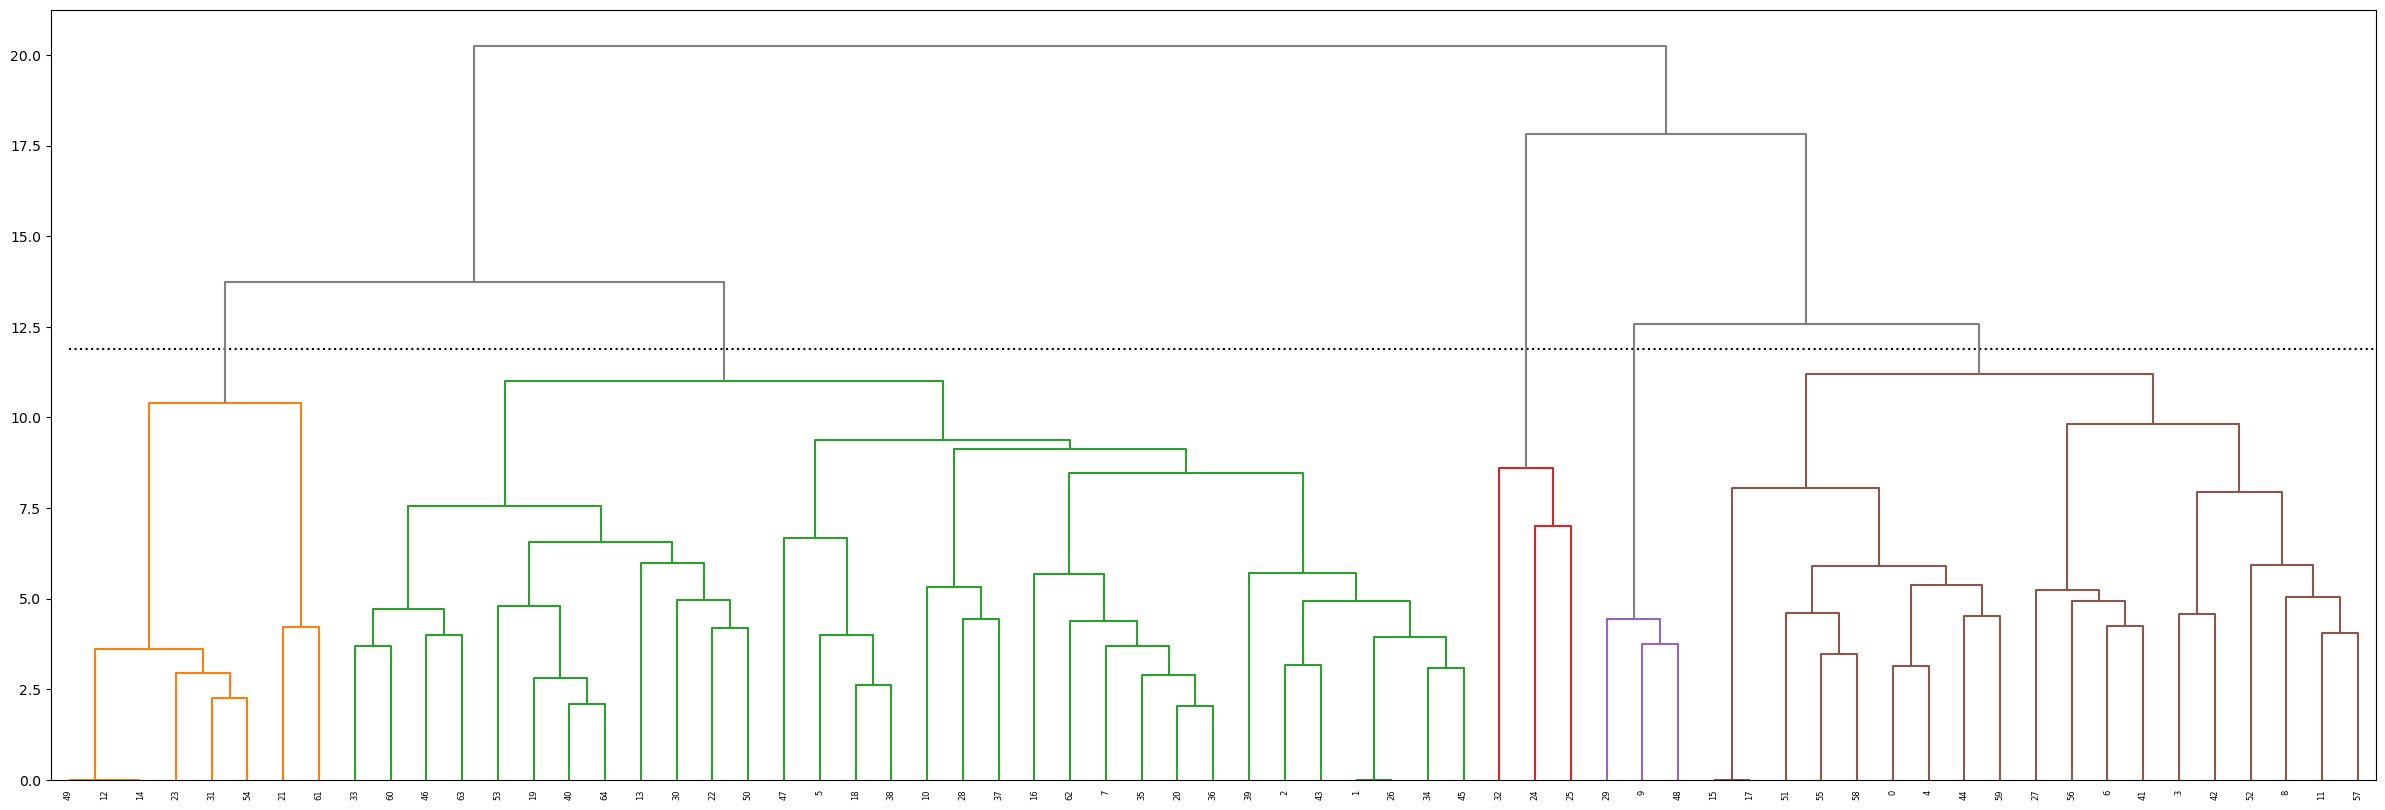

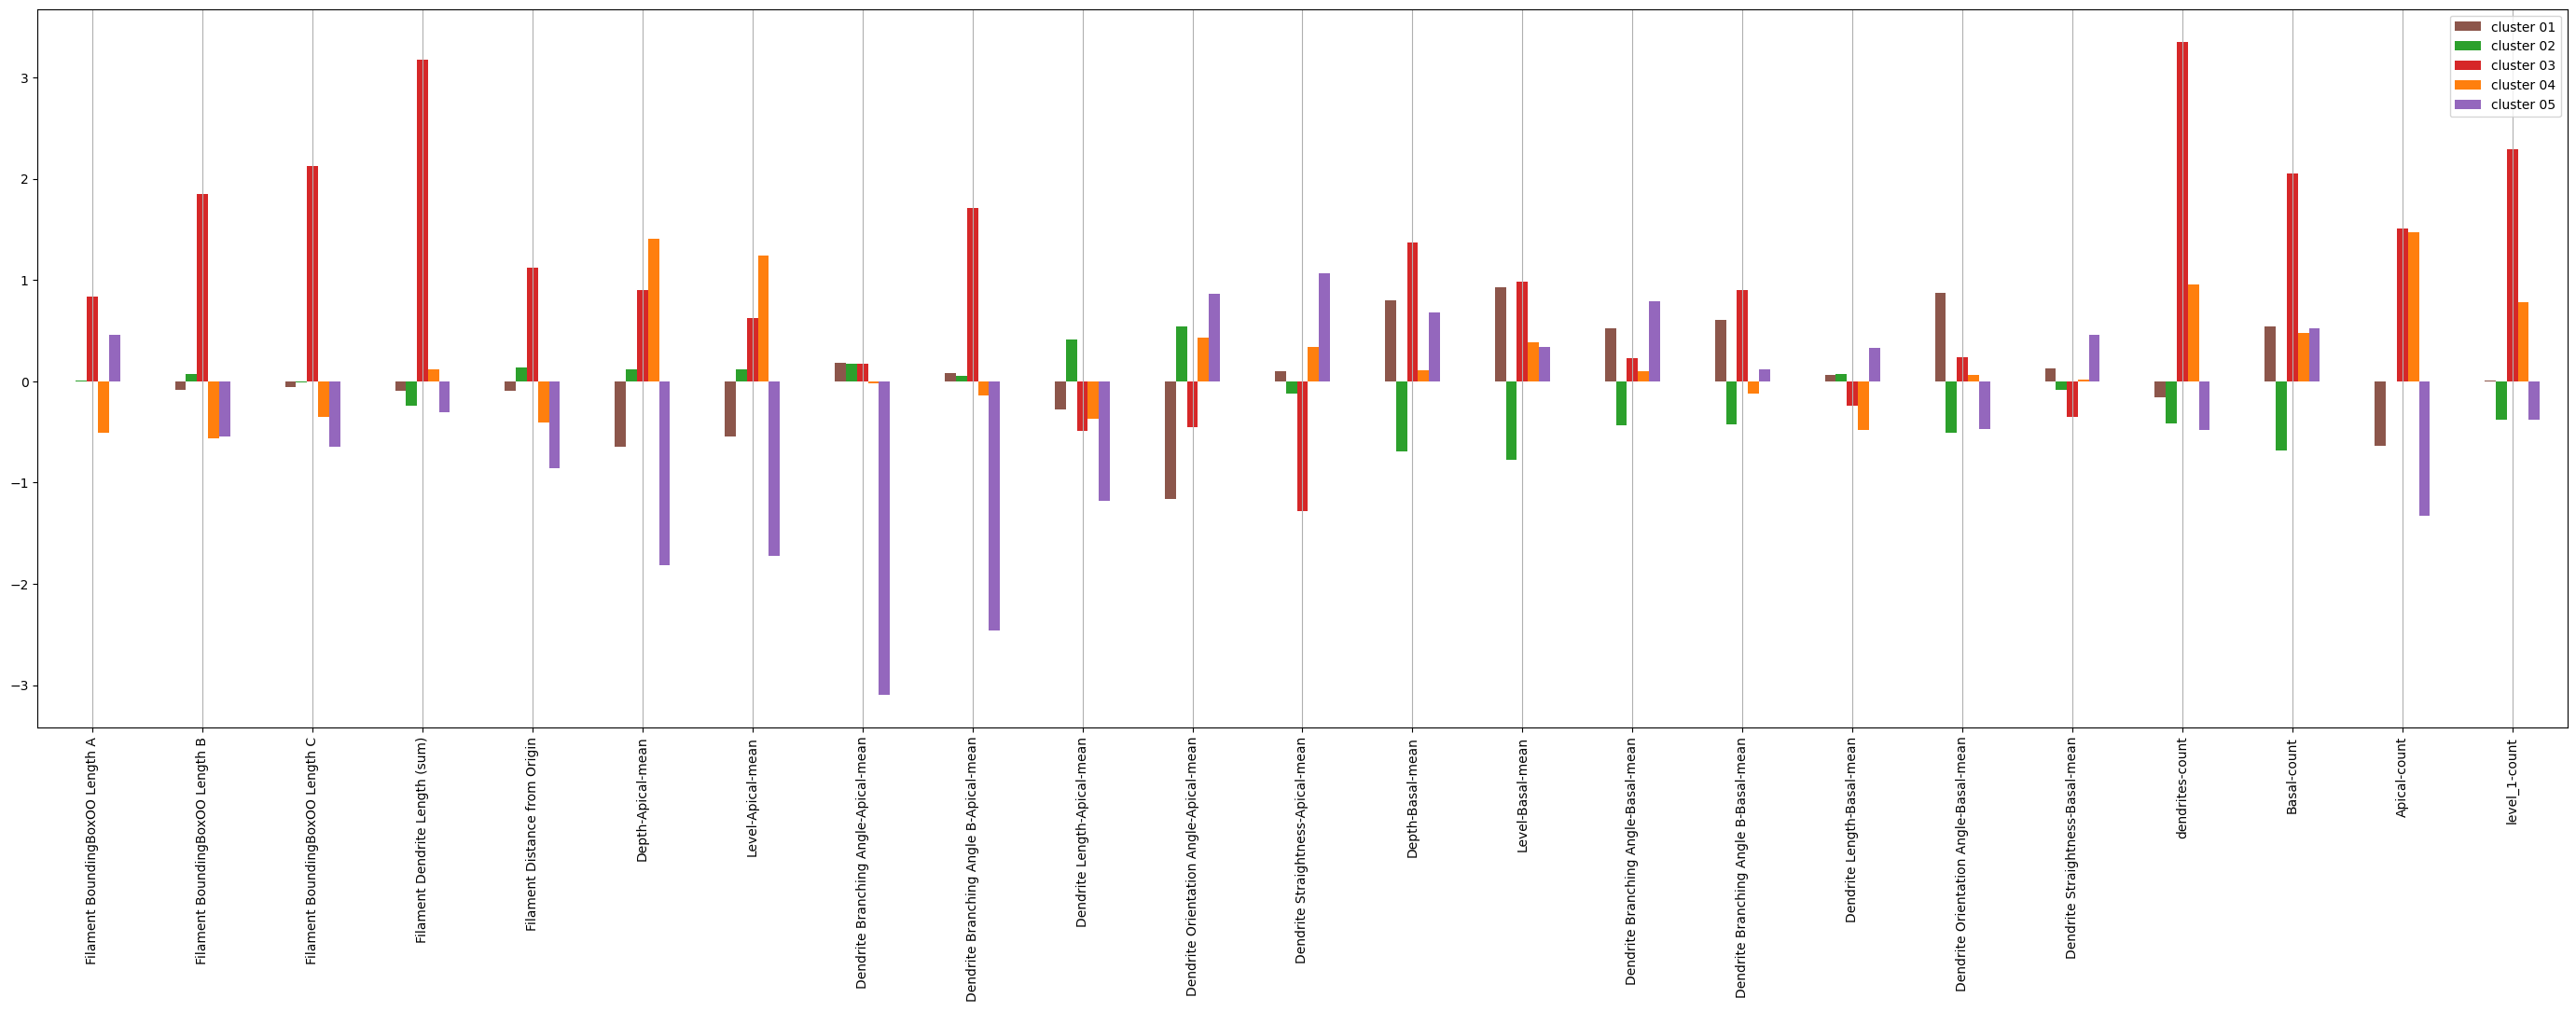

In [9]:
importlib.reload(cluster)

cluster_model, label_2_color = cluster.hierarchical_cstm(cluster_df, d_thresh = 11.9, figsize = (30, 10))

labels = cluster_model.labels_
n_clusters = labels.max() + 1

#plotting_tools.save_figure(op.join(f'/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons/figures/hierarchical-tree-{n_clusters:02d}k.png'))

# full_model, feature_df_nona.iloc[:, 1:], plot = True, col = lab2col
centroids = cluster.get_centroids(cluster_model, cluster_df, col = label_2_color, plot = True)

#plotting_tools.save_figure(op.join(f'/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons/figures/hierarchical-centroids-{n_clusters:02d}k.png'))

dist_to_centroid = cluster.get_centroid_distance(cluster_model, cluster_df, centroids)

dist_to_centroid

In [10]:
print('Features with the least in-cluster variance:')

for i, cluster_features in enumerate(dist_to_centroid.feat_by_radius):
    print(f'cluster {i:d}', cluster_features[:4])

Features with the least in-cluster variance:
cluster 0 ['Apical-count', 'dendrites-count', 'Dendrite Branching Angle-Basal-mean', 'Depth-Apical-mean']
cluster 1 ['dendrites-count', 'Basal-count', 'Dendrite Orientation Angle-Apical-mean', 'Level-Basal-mean']
cluster 2 ['Dendrite Branching Angle-Basal-mean', 'Dendrite Branching Angle B-Apical-mean', 'Dendrite Branching Angle B-Basal-mean', 'Dendrite Orientation Angle-Apical-mean']
cluster 3 ['Depth-Basal-mean', 'Dendrite Branching Angle B-Basal-mean', 'Level-Basal-mean', 'Dendrite Straightness-Basal-mean']
cluster 4 ['Dendrite Branching Angle B-Apical-mean', 'Depth-Apical-mean', 'Level-Apical-mean', 'Apical-count']


In [11]:
labels

for i in range(n_clusters):
    print(f'Cluster {i + 1} :', cluster_df.loc[labels == i].index.tolist())

label_save_df = cluster_df.iloc[:, :1]
label_save_df[f'labels-{n_clusters}k'] = labels

label_save_df = label_save_df.drop(columns = ['Filament BoundingBoxOO Length A'])

label_save_df.to_csv('/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons/neuron_clustering.csv')

Cluster 1 : ['220803c2', '220831c4', '220729c3', '220729c6', '220804c7', '220831c6', '22072c4', '220728c4', '220729c4', '220803c6', '220909c3', '220804c6', '220804c3', '220831c5', '220802c6', '220729c5', '220902c4', '220804c9', '220804c4']
Cluster 2 : ['220728c6', '220804c2', '221022c1', '220802c2', '221003c1', '220726c8', '220726t2', '220729c1', '220802c5', '220802c11', '221003c3', '220728c6-', '220804c8', '220905c3', '220905c1', '221005c2', '220728c2', '220728c3', '220804c5', '221003c5', '221003c8', '220726c1', '220802c3-', '220909c4', '220726c3', '220909c2', '220726c7', '220727c4-', '220802c9', '220804c1', '220802c4-', '220802c10']
Cluster 3 : ['221003c7', '220905c2', '221003c4']
Cluster 4 : ['220728c7', '220728c62', '220728c5', '220728c9', '221003c6', '220728c7', '220729c2', '220728c5']
Cluster 5 : ['220909c5', '220902c5', '220803c3']


/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37278/1113683998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_save_df[f'labels-{n_clusters}k'] = labels


OSError: Cannot save file into a non-existent directory: '/Users/AlexCionca/Documents/BrainHack-2023/Piriform_neurons'